# Adversarial Learning

In this notebook, we will go through basics of Adversarial Learning through two attacks - non-targeted and targeted attacks on a given input car image. We will use cleverhans library.

Here we will use [tensorflow](http://tensorflow.org/  "Tensorflow Homepage").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/adversarial/learning/2019/03/04/Mystery-of-Adversarial-Learning/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Adversarial%20Learning/adv_learning_tf.ipynb)



In [1]:
#upload input image 

from google.colab import files
files.upload()

{}

In [0]:
!pip install cleverhans

     |████████████████████████████████| 204kB 2.8MB/s 
     |████████████████████████████████| 51kB 22.0MB/s 


In [0]:
from io import BytesIO
import IPython.display
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.contrib.slim.nets import inception
from cleverhans.attacks import FastGradientMethod
from cleverhans.model import Model
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
slim = tf.contrib.slim

Using TensorFlow backend.


In [0]:
incept_model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 2s 0us/step


([], <a list of 0 Text yticklabel objects>)

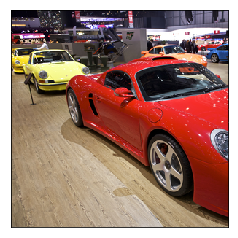

In [0]:
img_path = 'input.png'
img = image.load_img(img_path, target_size=(299, 299))
plt.imshow(img)
plt.xticks([])
plt.yticks([])

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
preds = incept_model.predict(x)

In [0]:
print('Inception Prediction:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Inception Prediction: [('n04285008', 'sports_car', 0.92233455), ('n02974003', 'car_wheel', 0.015271122), ('n04037443', 'racer', 0.009670077)]


# Non-targeted Adversarial Attack

Kaggle Competition : [Link](https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/)

The non-targeted challenge focuses on tricking the classifier with any other class.


## Using cleverhans library

Code Adapted from: [Link](https://www.kaggle.com/benhamner/adversarial-learning-challenges-getting-started)

**Not working as intended**

In [0]:
class InceptionModel(Model):
    def __init__(self, scope, num_classes):
        Model.__init__(self, scope, num_classes)
        self.num_classes = num_classes
        self.built = False
        
    def fprop(self, x_input):
        """Constructs model and return probabilities for given input."""
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            logits, end_points = inception.inception_v3(
                            x_input, num_classes=self.num_classes, is_training=False,
                            reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        probs = output.op.inputs[0]
        return {self.O_LOGITS: logits,
                self.O_PROBS: tf.nn.softmax(logits=logits)}

In [0]:
# Create TF session and set as Keras backend session
eps = 0.3
batch_shape = [1, 299, 299, 3]
num_classes = 1000

In [0]:
def show_image(a, fmt='png'):
    
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
dim is deprecated, use axis instead
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The original image is on the left, and the nontargeted adversarial image is on the right.


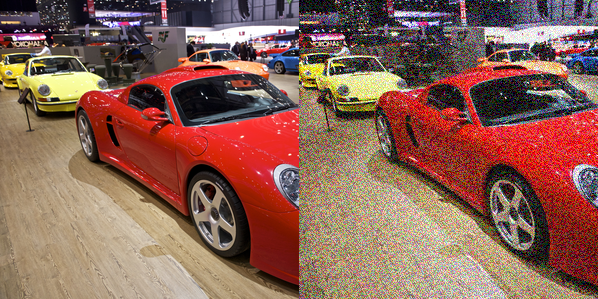

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)
    model = InceptionModel('incept_model', num_classes)

    fgsm  = FastGradientMethod(model)
    x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

    session_creator = tf.train.ChiefSessionCreator()

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        nontargeted_images = sess.run(x_adv, feed_dict={x_input: x})

print("The original image is on the left, and the nontargeted adversarial image is on the right.")
show_image(np.concatenate([x[0], nontargeted_images[0]], axis=1))


In [0]:
nontargeted_images.shape

(1, 299, 299, 3)

In [0]:
incept_model = InceptionV3(weights='imagenet')
preds = incept_model.predict(nontargeted_images)

In [0]:
print('Advesarial Prediction:', decode_predictions(preds, top=3)[0])

Advesarial Prediction: [('n04285008', 'sports_car', 0.8144518), ('n02974003', 'car_wheel', 0.05202862), ('n04037443', 'racer', 0.04427321)]


## Using gradients




In [0]:
steps = 40
step_alpha = 0.01
eps = 2 * 8 / 225.
K.clear_session()
session = tf.Session()
K.set_session(session)
incept_model = InceptionV3(weights='imagenet')

In [0]:
def non_targeted_attack(x):
    
    original_arr = x
    
    for step in range(steps):
        
        with session.as_default():
            with session.graph.as_default():
                
                print ("Step:", step)
                loss = K.mean(incept_model.output[:, np.argmax(incept_model.predict(x))])
                grads = K.gradients(loss, incept_model.input)[0]
                iterate = K.function([incept_model.input], [loss, grads])
                loss, grad = iterate([x])

                normed_grad = step_alpha * K.sign(grad)
                step_adv = x - normed_grad
                adv = step_adv - original_arr
                adv = K.clip(adv, -eps, eps)

                result = original_arr + adv
                result = K.clip(result, 0.0, 1.0)
                x = result.eval()
                
                if step == steps-1:
                    res = result.eval()
                    ad = adv.eval()
                
    return res, ad

In [0]:
adv_img, noise = non_targeted_attack(x)

Step: 0
Instructions for updating:
Use tf.cast instead.
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39


In [0]:
x[0].shape, noise[0].shape, adv_img[0].shape

((299, 299, 3), (299, 299, 3), (299, 299, 3))

In [0]:
def get_class(nontargeted_images):
    preds = incept_model.predict(nontargeted_images)
    cls = decode_predictions(preds, top=1)[0]
    return cls


def show_image(img, x, noise, adv_img):
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(x), get_class(adv_img)
    ax[0].imshow(img)
    ax[0].set_title('Original image: {} {:.2f}'.format(orig_class[0][1], orig_class[0][2]))
    ax[1].imshow(Image.fromarray(np.uint8((noise[0])*255)))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(Image.fromarray(np.uint8((adv_img[0])*255)))
    ax[2].set_title('Adversarial example: {} {:.2f}'.format(attack_class[0][1], attack_class[0][2]))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

The original image is on the left, the center image is noise and the nontargeted adversarial image is on the right.


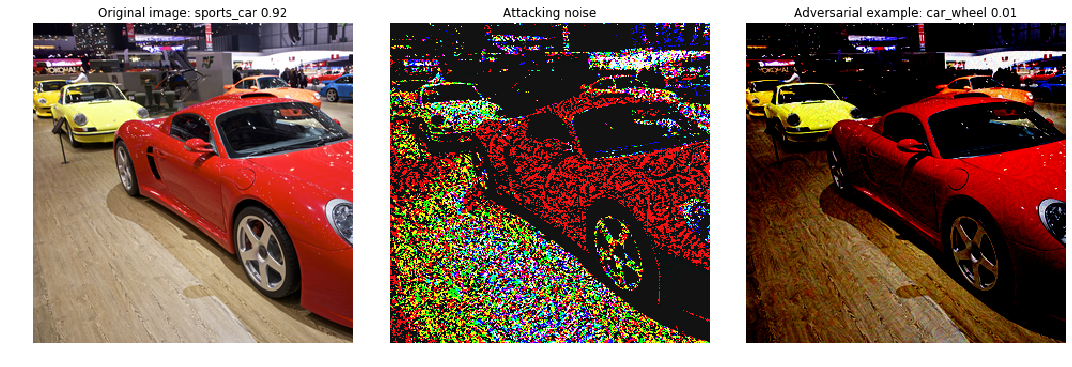

In [0]:
print("The original image is on the left, the center image is noise and the nontargeted adversarial image is on the right.")
show_image(img, x, noise, adv_img)

In [0]:
incept_model = InceptionV3(weights='imagenet')
preds = incept_model.predict(adv_img)

In [0]:
print('Non-targeted Advesarial Prediction:', decode_predictions(preds, top=3)[0])

Non-targeted Advesarial Prediction: [('n02974003', 'car_wheel', 0.0051993676), ('n04296562', 'stage', 0.0050075585), ('n04285008', 'sports_car', 0.0049539097)]


# Targeted Adversarial Attack

Kaggle Competition : [Link](https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/)


## Using gradients

In [0]:
steps = 40
step_alpha = 0.01
eps = 2 * 8 / 225.
K.clear_session()
session = tf.Session()
K.set_session(session)
incept_model = InceptionV3(weights='imagenet')

In [0]:
def targeted_attack(x, label_idx):
    
    original_arr = x
    
    for step in range(steps):
        
        with session.as_default():
            with session.graph.as_default():
                
                print ("Step:", step)
                loss = K.mean(incept_model.output[:, label_idx])
                grads = K.gradients(loss, incept_model.input)[0]
                iterate = K.function([incept_model.input], [loss, grads])
                loss, grad = iterate([x])

                normed_grad = step_alpha * K.sign(grad)
                step_adv = x + normed_grad
                adv = step_adv - original_arr
                adv = K.clip(adv, -eps, eps)

                result = original_arr + adv
                result = K.clip(result, 0.0, 1.0)
                x = result.eval()
                
                res = result.eval()
                ad = adv.eval()
                
    return res, ad

In [0]:
targeted_adv_img, noise = targeted_attack(x, 859)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39


In [0]:
x[0].shape, noise[0].shape, targeted_adv_img[0].shape

((299, 299, 3), (299, 299, 3), (299, 299, 3))

In [0]:
def get_class(targeted_images):
    preds = incept_model.predict(targeted_images)
    cls = decode_predictions(preds, top=1)[0]
    return cls


def show_image(img, x, noise, adv_img):
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(x), get_class(adv_img)
    ax[0].imshow(img)
    ax[0].set_title('Original image: {} {:.2f}'.format(orig_class[0][1], orig_class[0][2]))
    ax[1].imshow(Image.fromarray(np.uint8((noise[0])*255)))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(Image.fromarray(np.uint8((adv_img[0])*255)))
    ax[2].set_title('Adversarial example: {} {:.2f}'.format(attack_class[0][1], attack_class[0][2]))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

The original image is on the left, the center image is noise and the targeted adversarial image is on the right.


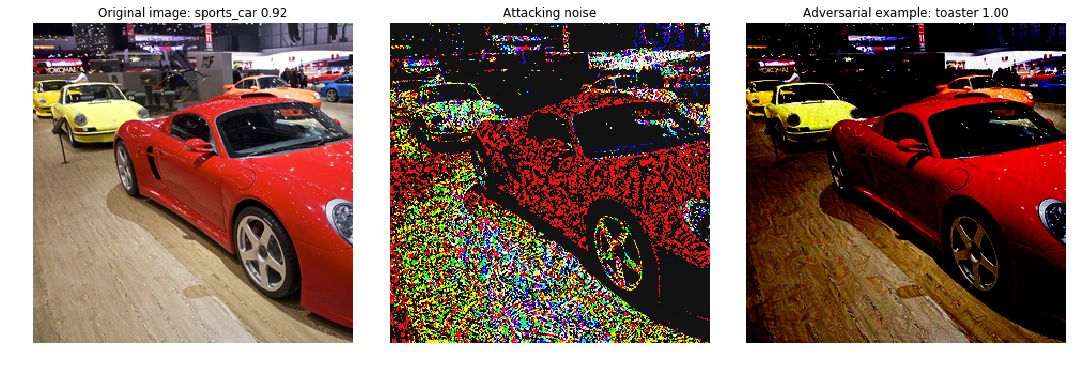

In [0]:
print("The original image is on the left, the center image is noise and the targeted adversarial image is on the right.")
show_image(img, x, noise, targeted_adv_img)

In [0]:
incept_model = InceptionV3(weights='imagenet')
preds = incept_model.predict(targeted_adv_img)

In [0]:
print('Targeted Advesarial Prediction:', decode_predictions(preds, top=3)[0])

Targeted Advesarial Prediction: [('n04442312', 'toaster', 1.0), ('n03133878', 'Crock_Pot', 2.1688722e-09), ('n01877812', 'wallaby', 1.4294415e-09)]
